Data Loading Activity Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = '/content/drive/MyDrive/adhd-datasets/adhd-diagnosis.zip'
extract_path = '/content/drive/MyDrive/adhd-datasets/extracted_adhd'


In [ ]:
import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
## set path to the data
activity_folder = '/content/drive/MyDrive/adhd-datasets/extracted_adhd/hyperaktiv_with_controls/hyperaktiv_with_controls/activity_data'
patient_info_path = '/content/drive/MyDrive/adhd-datasets/extracted_adhd/hyperaktiv_with_controls/hyperaktiv_with_controls/patient_info.csv'

In [ ]:
## reading the data
with open(patient_info_path, 'r') as f:
    for _ in range(5):
        print(f.readline())


ID;SEX;AGE;ACC;ACC_TIME;ACC_DAYS;HRV;HRV_TIME;HRV_HOURS;CPT_II;ADHD;ADD;BIPOLAR;UNIPOLAR;ANXIETY;SUBSTANCE;OTHER;CT;MDQ_POS;WURS;ASRS;MADRS;HADS_A;HADS_D;MED;MED_Antidepr;MED_Moodstab;MED_Antipsych;MED_Anxiety_Benzo;MED_Sleep;MED_Analgesics_Opioids;MED_Stimulants;filter_$

1;0;3;1;16:00:00;6;1;11:00:00;21;0;1;0;1;0;1;0;1;1;1;54;53;26;12;2;1;1;;;;;;;1

2;0;4;1;10:54:00;6.8;0;;;1;1;0;0;1;0;0;1;1;1;83;62;11;2;7;0;;;;;;;;1

3;1;2;1;15:28:00;7.2;1;15:25:00;21;1;1;0;1;0;0;1;0;0;0;72;60;6;8;0;0;;;;;;;;1

4;1;3;0;;;1;16:55:00;22;1;1;0;1;0;1;1;0;0;9;82;46;19;12;6;1;1;;;1;;1;;0



In [ ]:
import pandas as pd

patient_df = pd.read_csv(patient_info_path, delimiter=';')

# Convert 'ID' column to  PatientID in activity data files
patient_df['ID'] = patient_df['ID'].astype(str)

# Rename 'ID' column to 'PatientID'
patient_df.rename(columns={'ID': 'PatientID'}, inplace=True)


patient_df = patient_df[['PatientID', 'ADHD']]


patient_df.head()


,PatientID,ADHD
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [ ]:
## Reading all the dataframes into one csv files activity data
import os
import numpy as np
import pandas as pd

summary_data = []


for filename in os.listdir(activity_folder):
    if filename.endswith('.csv'):
        patient_id = os.path.splitext(filename)[0]
        file_path = os.path.join(activity_folder, filename)

        try:
            # Explicitly separator as ';'
            df = pd.read_csv(file_path, delimiter=';')
            #removing date and time
            df = df.select_dtypes(include=[np.number])
            if df.empty:
                print(f"Warning: {filename} contains no numeric columns after filtering.")
                continue
            # statistics
            stats = df.describe().loc[['mean', 'std', 'min', 'max']].stack().to_frame().T
            stats.columns = [f"{col[0]}_{col[1]}" for col in stats.columns]
            stats['PatientID'] = patient_id
            summary_data.append(stats)
        except Exception as e:
            print(f"Failed to process {filename}: {e}")
# Combine all patient
if summary_data:
    activity_summary_df = pd.concat(summary_data, ignore_index=True)
else:
    print("Error: No data found to create activity summary DataFrame.")
    activity_summary_df = pd.DataFrame()

In [ ]:
#  numeric
activity_summary_df['PatientID'] = activity_summary_df['PatientID'].str.extract('(\d+)')

# Convert to string to match patient_df type
activity_summary_df['PatientID'] = activity_summary_df['PatientID'].astype(str)

print("Cleaned Patient IDs :", activity_summary_df['PatientID'].unique())


Cleaned Patient IDs in activity_summary_df: ['01' '02' '03' '05' '07' '08' '09' '10' '101' '104' '105' '108' '11' '13'
 '14' '15' '18' '19' '20' '21' '210' '211' '212' '213' '214' '215' '216'
 '217' '218' '219' '22' '220' '221' '222' '223' '224' '225' '226' '227'
 '228' '229' '23' '230' '231' '232' '233' '234' '235' '236' '237' '238'
 '239' '24' '240' '26' '27' '30' '31' '32' '33' '34' '35' '36' '37' '39'
 '41' '42' '43' '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '55'
 '56' '57' '58' '59' '60' '61' '63' '64' '65' '67' '68' '70' '71' '72'
 '73' '74' '75' '77' '78' '79' '81' '82' '83' '84' '85' '87' '88' '89'
 '90' '91' '92' '93' '94' '95' '96' '97' '98']


In [ ]:
# merge
final_df = pd.merge(activity_summary_df, patient_df, on='PatientID', how='inner')

if final_df.empty:
    print("Warning: Merged DataFrame is empty. No matching PatientIDs found.")
else:
    print(f"Merged DataFrame contains {len(final_df)} rows.")

print(final_df.head())


Merged DataFrame contains 109 rows.
   mean_ACTIVITY  std_ACTIVITY  min_ACTIVITY  max_ACTIVITY PatientID  ADHD
0      68.401202    112.654471           0.0        1726.0        10     0
1     244.928216    387.405119           0.0        5249.0       101     0
2     355.351822    438.648252           0.0        2845.0       104     0
3     304.001188    508.259089           0.0        6128.0       105     0
4     353.157053    457.802399           0.0        3637.0       108     1


In [ ]:
# Reorder
columns = ['PatientID'] + [col for col in final_df.columns if col != 'PatientID']
final_df = final_df[columns]

print(final_df.head())


  PatientID  mean_ACTIVITY  std_ACTIVITY  min_ACTIVITY  max_ACTIVITY  ADHD
0        10      68.401202    112.654471           0.0        1726.0     0
1       101     244.928216    387.405119           0.0        5249.0     0
2       104     355.351822    438.648252           0.0        2845.0     0
3       105     304.001188    508.259089           0.0        6128.0     0
4       108     353.157053    457.802399           0.0        3637.0     1


In [ ]:
#Split the Data into Training and Testing Sets

from sklearn.model_selection import train_test_split

# x & y targets
X = final_df.drop(columns=['PatientID', 'ADHD'])
y = final_df['ADHD']  # ADHD is the target variable

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the resulting datasets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 87 samples
Test set size: 22 samples


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.50      0.91      0.65        11
           1       0.50      0.09      0.15        11

    accuracy                           0.50        22
   macro avg       0.50      0.50      0.40        22
weighted avg       0.50      0.50      0.40        22



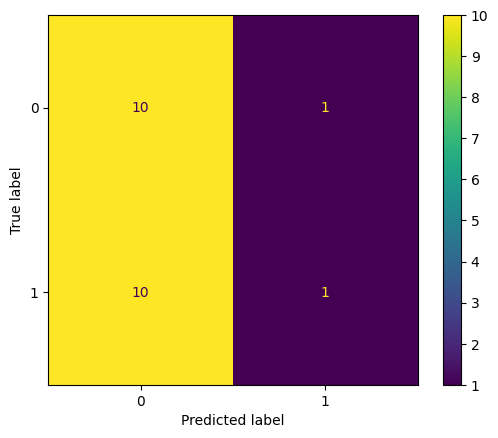

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [ ]:
#Model Training (DNN)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define the DNN Model Architecture
model = Sequential()
# Input layer with 64 units and ReLU activation
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
# Hidden layer with 32 units and ReLU activation
model.add(Dense(32, activation='relu'))
# Output layer with 1 unit and sigmoid activation
model.add(Dense(1, activation='sigmoid'))
# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001),  #Adam optimizer with learning rate 0.001
              loss='binary_crossentropy',
              metrics=['accuracy'])  #Accuracy metric
# Train the Model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    verbose=1)
# Model Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6615 - loss: 0.6685 - val_accuracy: 0.5455 - val_loss: 0.7098
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6672 - loss: 0.6535 - val_accuracy: 0.5000 - val_loss: 0.7145
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6479 - loss: 0.6381 - val_accuracy: 0.5000 - val_loss: 0.7204
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6615 - loss: 0.6300 - val_accuracy: 0.5000 - val_loss: 0.7290
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6615 - loss: 0.6261 - val_accuracy: 0.5000 - val_loss: 0.7381
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6732 - loss: 0.6053 - val_accuracy: 0.5000 - val_loss: 0.7483
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6458 - loss: 0.6125 - val_accuracy: 0.5000 - val_loss: 0.7579
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6888 - loss: 0.5992 - val_accuracy: 0.5000 - val_loss: 0.7681
Epoch 9/20

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6458 - loss: 0.6065 - val_accuracy: 0.5000 - val_loss: 0.8180
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6302 - loss: 0.6248 - val_accuracy: 0.5000 - val_loss: 0.8187
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6576 - loss: 0.5916 - val_accuracy: 0.5000 - val_loss: 0.8205
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6615 - loss: 0.5831 - val_accuracy: 0.5000 - val_loss: 0.8230
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6576 - loss: 0.5947 - val_accuracy: 0.5000 - val_loss: 0.8239
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6732 - loss: 0.5750 - val_accuracy: 0.5000 - val_loss: 0.8267
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6576 - loss: 0.5875 - val_accuracy: 0.5000 - val_loss: 0.8273
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6362 - loss: 0.5837 - val_accuracy: 0.5000 - val_loss: 0.8291


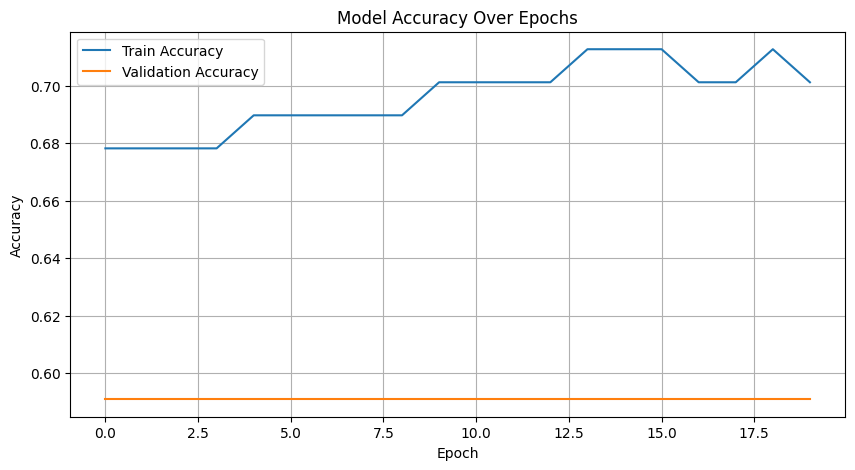

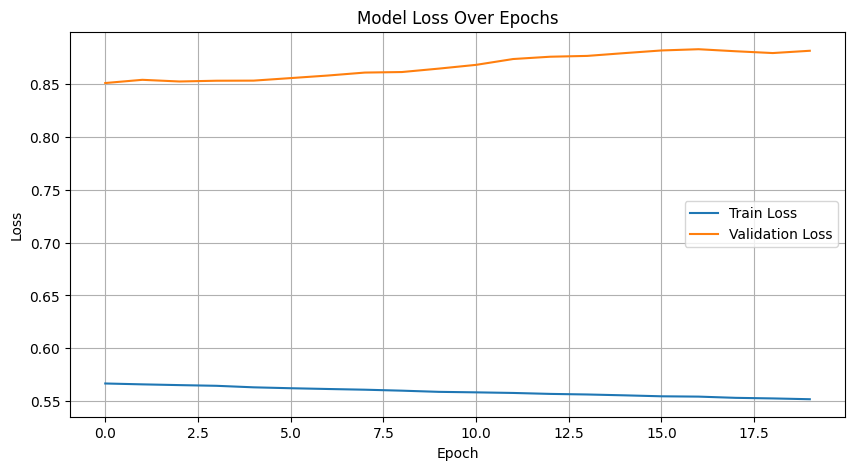

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

